2025-07-02 17:42:05.791772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751478125.837385      95 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751478125.845360      95 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


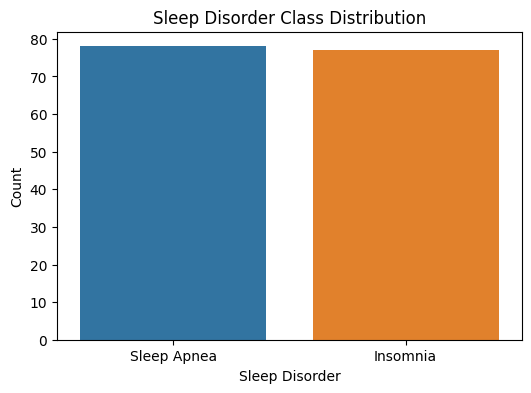

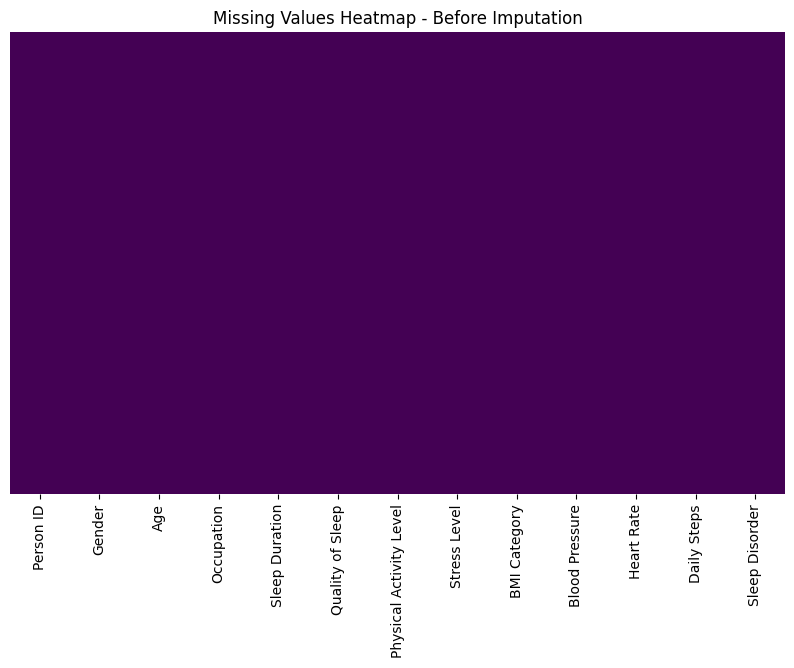


Missing values count per column before imputation:
Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64


/tmp/ipykernel_95/1351907491.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_95/1351907491.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

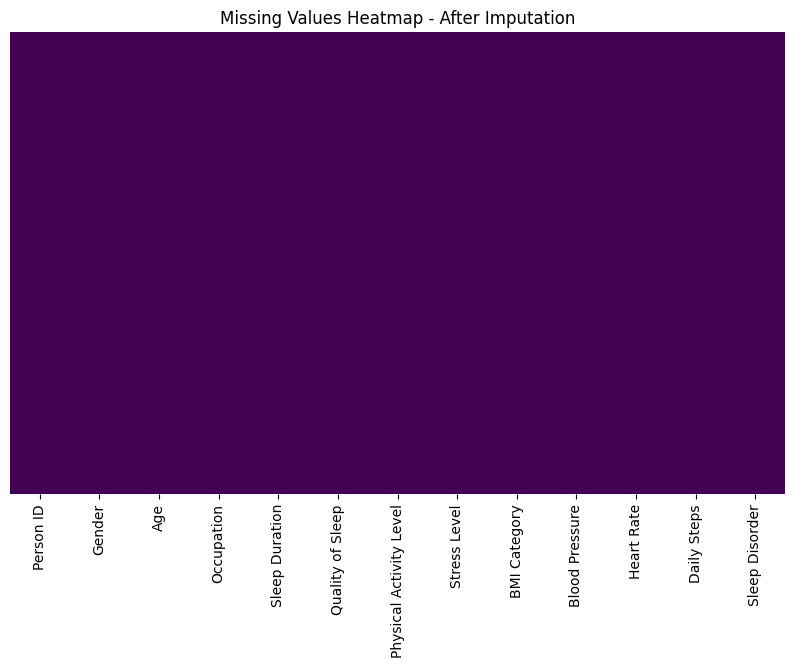


Missing values count per column after imputation:
Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64


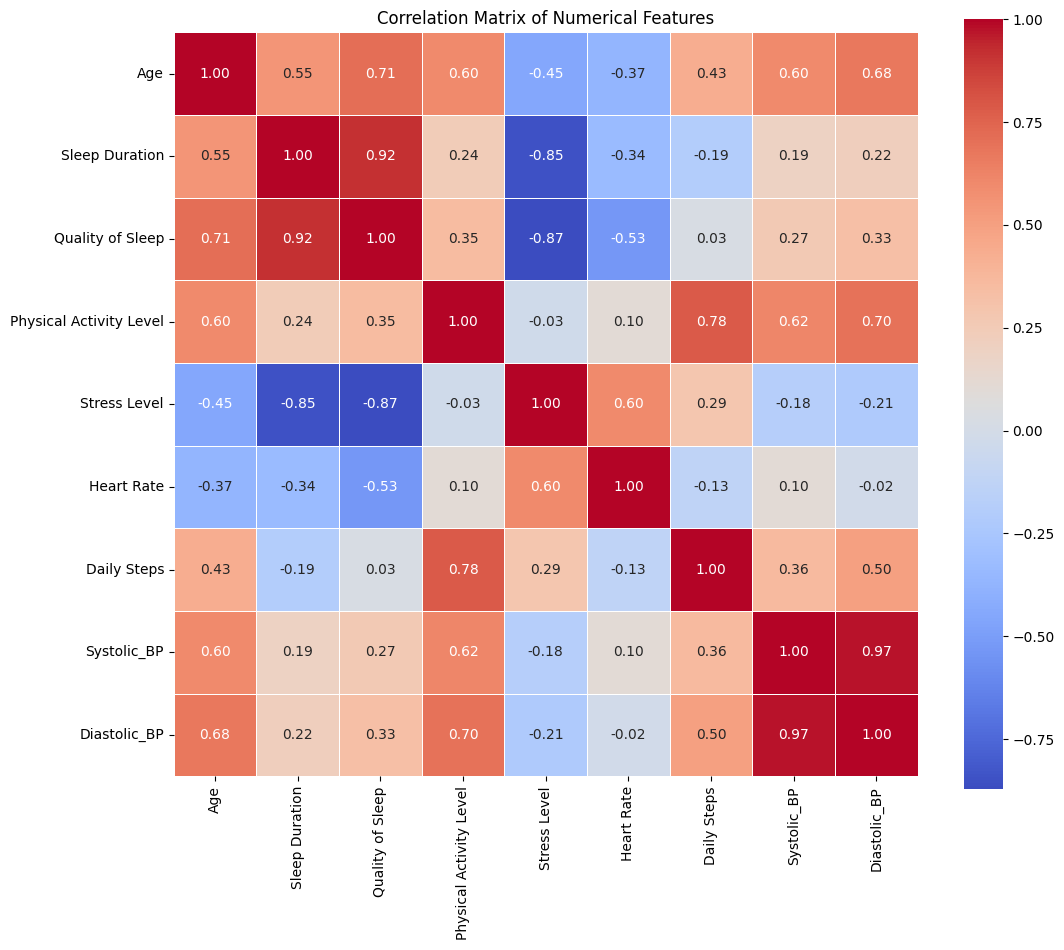

Train shape: (124, 12, 1), Test shape: (31, 12, 1)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle

# --- Step 0: Load Dataset ---
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# --- Step 1: Drop rows with missing target ---
df = df.dropna(subset=['Sleep Disorder'])

# --- Step 2: Visualize class distribution ---
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sleep Disorder', order=df['Sleep Disorder'].value_counts().index)
plt.title("Sleep Disorder Class Distribution")
plt.xlabel("Sleep Disorder")
plt.ylabel("Count")
plt.show()

# --- Step 3: Visualize missing values before imputation ---
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap - Before Imputation")
plt.show()

print("\nMissing values count per column before imputation:")
print(df.isnull().sum())

# --- Step 4: Fix missing values ---

# Numerical columns
num_cols = ['Sleep Duration', 'Stress Level']
for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Categorical column
df['Blood Pressure'].fillna(df['Blood Pressure'].mode()[0], inplace=True)

# --- Step 5: Visualize missing values after imputation ---
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap - After Imputation")
plt.show()

print("\nMissing values count per column after imputation:")
print(df.isnull().sum())

# --- Step 6: Split Blood Pressure into Systolic and Diastolic ---
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(bp_split[0])
df['Diastolic_BP'] = pd.to_numeric(bp_split[1])
df.drop(columns=['Blood Pressure'], inplace=True)

# --- Step 7: Encode categorical features ---
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_occupation = LabelEncoder()
df['Occupation'] = le_occupation.fit_transform(df['Occupation'])

le_bmi = LabelEncoder()
df['BMI Category'] = le_bmi.fit_transform(df['BMI Category'])

# --- Step 8: Show correlation matrix of numerical features ---
plt.figure(figsize=(12,10))
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP']
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# --- Step 9: Prepare features and target ---
X = df.drop(columns=['Person ID', 'Sleep Disorder'])
y = df['Sleep Disorder']

# Encode target labels
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)
y_cat = to_categorical(y_enc)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN input (samples, timesteps, features=1)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# --- Step 10: Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_cat, test_size=0.2, random_state=42, stratify=y_enc)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- Step 11: Save preprocessed data and encoders ---
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)


# SMOT

In [2]:
pip install --upgrade scikit-learn imbalanced-learn


  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

from tensorflow.keras.utils import to_categorical

# --- Load dataset ---
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# --- Handle missing target values ---
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# --- Numerical columns for imputation ---
num_cols = ['Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']

# --- Impute missing numeric values with mean ---
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# --- Fill missing Blood Pressure with mode ---
df['Blood Pressure'] = df['Blood Pressure'].fillna(df['Blood Pressure'].mode()[0])

# --- Split Blood Pressure into systolic and diastolic ---
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(bp_split[0])
df['Diastolic_BP'] = pd.to_numeric(bp_split[1])
df.drop(columns=['Blood Pressure'], inplace=True)

# --- Encode categorical features ---
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_occupation = LabelEncoder()
df['Occupation'] = le_occupation.fit_transform(df['Occupation'])

le_bmi = LabelEncoder()
df['BMI Category'] = le_bmi.fit_transform(df['BMI Category'])

# --- Encode target ---
le_target = LabelEncoder()
df['Sleep Disorder Encoded'] = le_target.fit_transform(df['Sleep Disorder'])

print("Class distribution before balancing:")
print(df['Sleep Disorder'].value_counts(normalize=True))

# --- Remove outliers using IQR method ---
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_clean = remove_outliers_iqr(df, num_cols + ['Age', 'Systolic_BP', 'Diastolic_BP'])

print(f"Shape after outlier removal: {df_clean.shape}")

# --- Prepare features and target ---
X = df_clean.drop(columns=['Person ID', 'Sleep Disorder', 'Sleep Disorder Encoded'])
y = df_clean['Sleep Disorder Encoded']

# --- Min-Max scaling ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- Split dataset: 70% train, 20% validation, 10% test (stratified) ---
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.10, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2222, random_state=42, stratify=y_temp)
    # 0.2222 * 0.90 ≈ 0.20 validation size

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

# --- Apply SMOTE only on training set ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(Counter(y_train_res))

# --- Reshape for CNN+BiLSTM+BiGRU: (samples, timesteps, features=1) ---
X_train_res_3d = X_train_res.reshape(X_train_res.shape[0], X_train_res.shape[1], 1)
X_val_3d = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# --- One-hot encode targets ---
y_train_cat = to_categorical(y_train_res)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print(f"Final training data shape: {X_train_res_3d.shape}, {y_train_cat.shape}")
print(f"Validation data shape: {X_val_3d.shape}, {y_val_cat.shape}")
print(f"Test data shape: {X_test_3d.shape}, {y_test_cat.shape}")

# Now your data is fully preprocessed, balanced, and ready for model training.


Class distribution before balancing:
Sleep Disorder
None           0.585561
Sleep Apnea    0.208556
Insomnia       0.205882
Name: proportion, dtype: float64
Shape after outlier removal: (359, 15)
Train shape: (251, 12), Validation shape: (72, 12), Test shape: (36, 12)
Class distribution after SMOTE:
Counter({1: 153, 0: 153, 2: 153})
Final training data shape: (459, 12, 1), (459, 3)
Validation data shape: (72, 12, 1), (72, 3)
Test data shape: (36, 12, 1), (36, 3)


# CNN+Bilstm+GRU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-02 17:56:29.304956: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,235 (622.01 KB)

 Trainable params: 159,235 (622.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.3451 - loss: 1.0942 - val_accuracy: 0.1944 - val_loss: 1.0898
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4020 - loss: 1.0504 - val_accuracy: 0.7917 - val_loss: 0.9502
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7920 - loss: 0.8697 - val_accuracy: 0.9167 - val_loss: 0.5681
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8549 - loss: 0.5617 - val_accuracy: 0.9306 - val_loss: 0.3523
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8716 - loss: 0.4708 - val_accuracy: 0.9306 - val_loss: 0.3048
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8882 - loss: 0.4065 - val_accuracy: 0.9306 - val_loss: 0.3150
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8847 - loss: 0.4301 - val_accuracy: 0.9306 - val_loss: 0.3238
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8907 - loss: 0.3850 - val_accuracy: 0

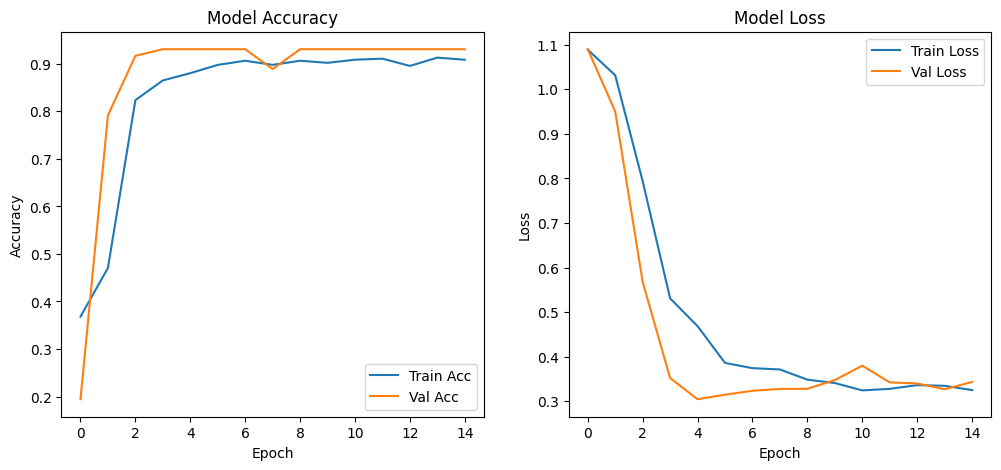

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8264 - loss: 0.5880
Test Accuracy: 0.8333
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

Classification Report:

              precision    recall  f1-score   support

    Insomnia       0.62      0.71      0.67         7
        None       0.90      0.86      0.88        22
 Sleep Apnea       0.86      0.86      0.86         7

    accuracy                           0.83        36
   macro avg       0.80      0.81      0.80        36
weighted avg       0.84      0.83      0.84        36



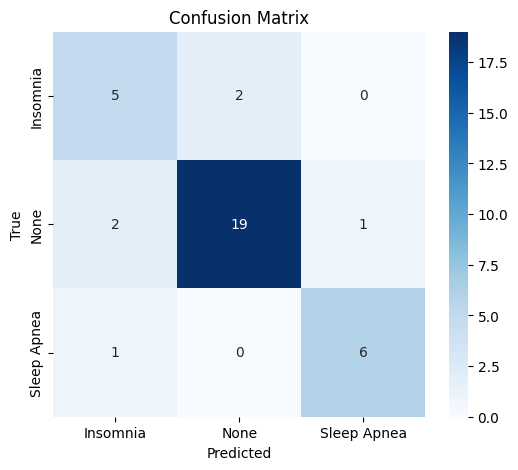

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming these variables are already available from your preprocessing step:
# X_train_res_3d, y_train_cat, X_val_3d, y_val_cat, X_test_3d, y_test_cat

num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)

# Build the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and classification report
y_pred_probs = model.predict(X_test_3d)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,635 (553.26 KB)

 Trainable params: 141,635 (553.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.3543 - loss: 1.0975 - val_accuracy: 0.7639 - val_loss: 1.0843
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4869 - loss: 1.0853 - val_accuracy: 0.6667 - val_loss: 1.0584
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7295 - loss: 1.0141 - val_accuracy: 0.8472 - val_loss: 0.8291
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8524 - loss: 0.6982 - val_accuracy: 0.9306 - val_loss: 0.3157
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8699 - loss: 0.5149 - val_accuracy: 0.9306 - val_loss: 0.2988
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8848 - loss: 0.5078 - val_accuracy: 0.9306 - val_loss: 0.3395
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8646 - loss: 0.4142 - val_accuracy: 0.9306 - val_loss: 0.3249
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8972 - loss: 0.3685 - val_accuracy: 0

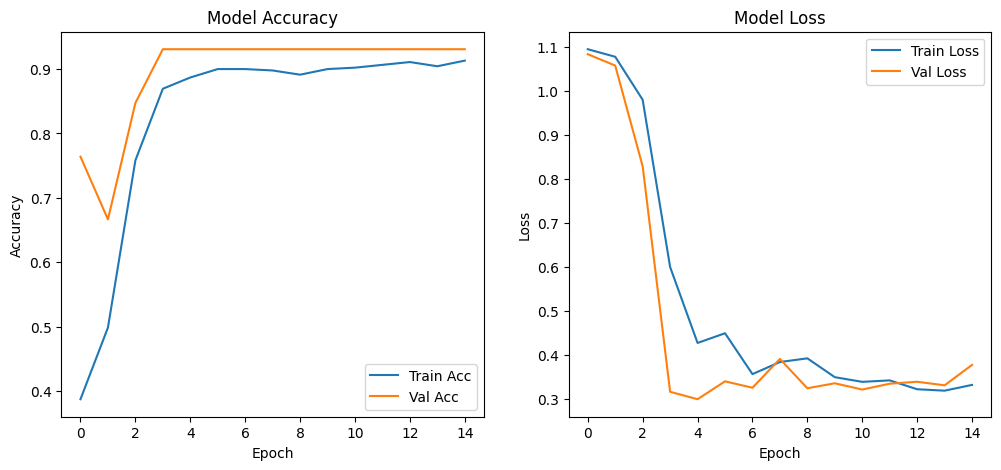

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8264 - loss: 0.6531
Test Accuracy: 0.8333
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 783ms/step

Classification Report:

              precision    recall  f1-score   support

    Insomnia       0.62      0.71      0.67         7
        None       0.90      0.86      0.88        22
 Sleep Apnea       0.86      0.86      0.86         7

    accuracy                           0.83        36
   macro avg       0.80      0.81      0.80        36
weighted avg       0.84      0.83      0.84        36



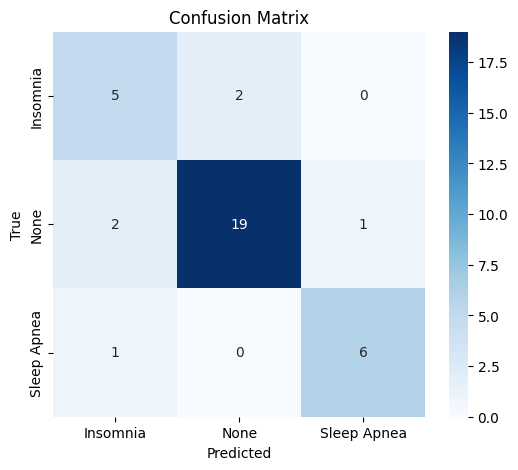

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)

# Build the model with CNN + BiLSTM + GRU
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    GRU(32),               # Unidirectional GRU layer
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test_3d)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le_target.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#  CNN + BiLSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,227 (516.51 KB)

 Trainable params: 132,227 (516.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.3871 - loss: 1.0934 - val_accuracy: 0.8611 - val_loss: 1.0663
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6807 - loss: 1.0502 - val_accuracy: 0.8611 - val_loss: 0.9444
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8979 - loss: 0.8399 - val_accuracy: 0.8889 - val_loss: 0.4874
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9164 - loss: 0.4515 - val_accuracy: 0.8889 - val_loss: 0.3593
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8798 - loss: 0.3946 - val_accuracy: 0.9306 - val_loss: 0.3261
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9061 - loss: 0.3528 - val_accuracy: 0.9306 - val_loss: 0.3543
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9038 - loss: 0.3388 - val_accuracy: 0.9306 - val_loss: 0.3270
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8826 - loss: 0.3715 - val_accuracy: 0.

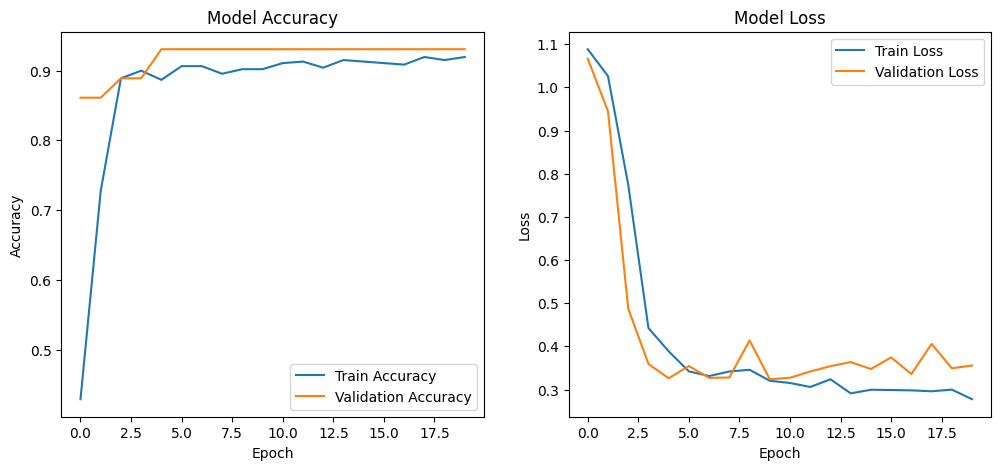

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8553 - loss: 0.5599
Test Accuracy: 0.8611
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step

Classification Report:

              precision    recall  f1-score   support

    Insomnia       0.71      0.71      0.71         7
        None       0.90      0.86      0.88        22
 Sleep Apnea       0.88      1.00      0.93         7

    accuracy                           0.86        36
   macro avg       0.83      0.86      0.84        36
weighted avg       0.86      0.86      0.86        36



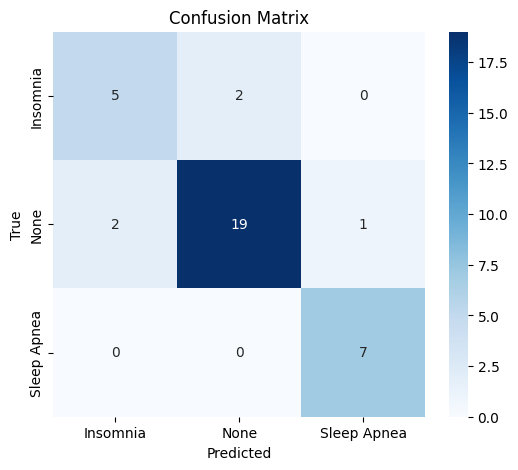

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)

# Build the model with CNN + BiLSTM
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and classification report
y_pred_probs = model.predict(X_test_3d)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_target.classes_, yticklabels=le_target.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 12, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 6, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 3, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,931 (456.76 KB)

 Trainable params: 116,547 (455.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6390 - loss: 0.8985 - val_accuracy: 0.3750 - val_loss: 1.0879
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9101 - loss: 0.3996 - val_accuracy: 0.9444 - val_loss: 1.0423
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9329 - loss: 0.3050 - val_accuracy: 0.6111 - val_loss: 1.0318
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9191 - loss: 0.3054 - val_accuracy: 0.6111 - val_loss: 1.0099
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9269 - loss: 0.2985 - val_accuracy: 0.6111 - val_loss: 0.9736
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9115 - loss: 0.2869 - val_accuracy: 0.6111 - val_loss: 0.9586
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9272 - loss: 0.2766 - val_accuracy: 0.6111 - val_loss: 0.9480
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9428 - loss: 0.2392 - val_accuracy: 0

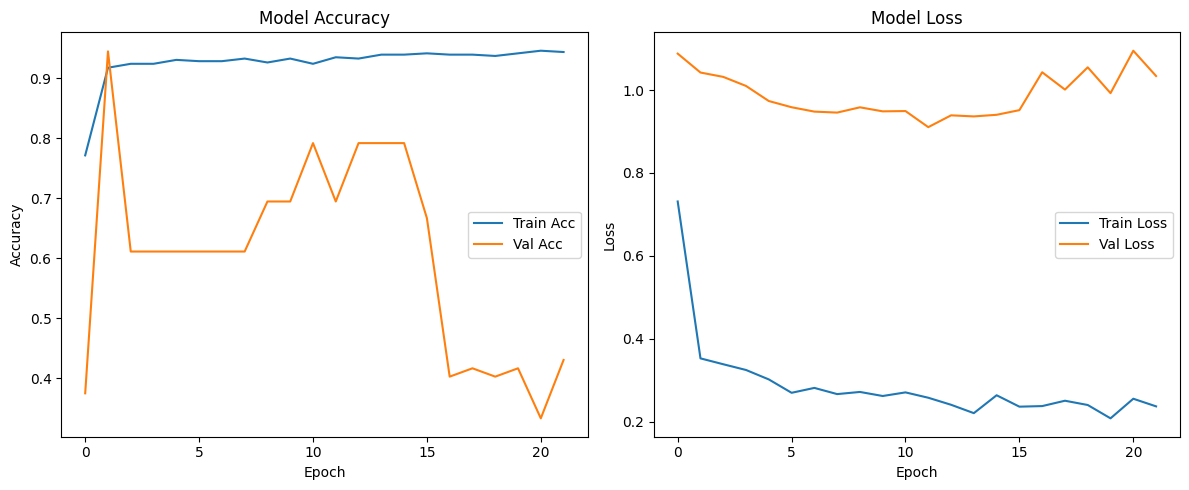

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6238 - loss: 0.9448

Test Accuracy: 0.6389
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step

Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.00      0.00      0.00         7
        None       0.64      0.95      0.76        22
 Sleep Apnea       0.67      0.29      0.40         7

    accuracy                           0.64        36
   macro avg       0.43      0.41      0.39        36
weighted avg       0.52      0.64      0.54        36



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


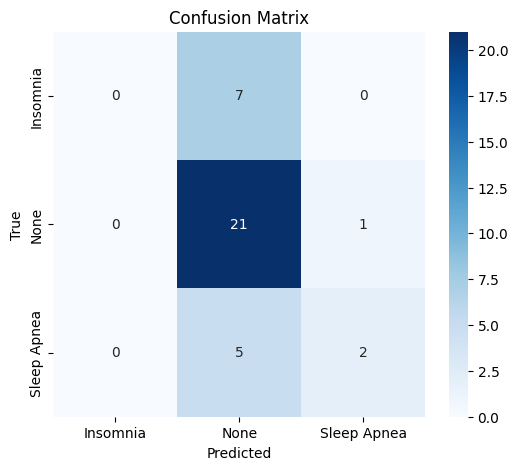

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Input and class shape
num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)

# New model architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=1, activation='relu'),  # 1x1 convolution to reduce dimensionality

    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# --- Plot Accuracy & Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- Test Evaluation ---
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.4f}")

# --- Predictions ---
y_pred_probs = model.predict(X_test_3d)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_target.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_81 (Conv1D)                   │ (None, 12, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_91 (LeakyReLU)           │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 12, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_78 (MaxPooling1D)      │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_188 (Dropout)                │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_82 (Conv1D)                   │ (None, 6, 64)               │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_92 (LeakyReLU)           │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_79 (MaxPooling1D)      │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_189 (Dropout)                │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_78 (Bidirectional)     │ (None, 3, 128)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_190 (Dropout)                │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_79 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_191 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_93 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_192 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,435 (478.26 KB)

 Trainable params: 122,243 (477.51 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/80
15/15 - 18s - 1s/step - accuracy: 0.6362 - loss: 0.9553 - val_accuracy: 0.1944 - val_loss: 1.1018
Epoch 2/80
15/15 - 0s - 16ms/step - accuracy: 0.7930 - loss: 0.6601 - val_accuracy: 0.6667 - val_loss: 1.0062
Epoch 3/80
15/15 - 0s - 15ms/step - accuracy: 0.8976 - loss: 0.4398 - val_accuracy: 0.8333 - val_loss: 0.8929
Epoch 4/80
15/15 - 0s - 15ms/step - accuracy: 0.9150 - loss: 0.3733 - val_accuracy: 0.7917 - val_loss: 0.8546
Epoch 5/80
15/15 - 0s - 16ms/step - accuracy: 0.9150 - loss: 0.3827 - val_accuracy: 0.6111 - val_loss: 0.8505
Epoch 6/80
15/15 - 0s - 16ms/step - accuracy: 0.9172 - loss: 0.3441 - val_accuracy: 0.6111 - val_loss: 0.8478
Epoch 7/80
15/15 - 0s - 16ms/step - accuracy: 0.9281 - loss: 0.3358 - val_accuracy: 0.6111 - val_loss: 0.8245
Epoch 8/80
15/15 - 0s - 16ms/step - accuracy: 0.9172 - loss: 0.3657 - val_accuracy: 0.6111 - val_loss: 0.8074
Epoch 9/80
15/15 - 0s - 16ms/step - accuracy: 0.9216 - loss: 0.3654 - val_accuracy: 0.6111 - val_loss: 0.8046
Epoch 10/80

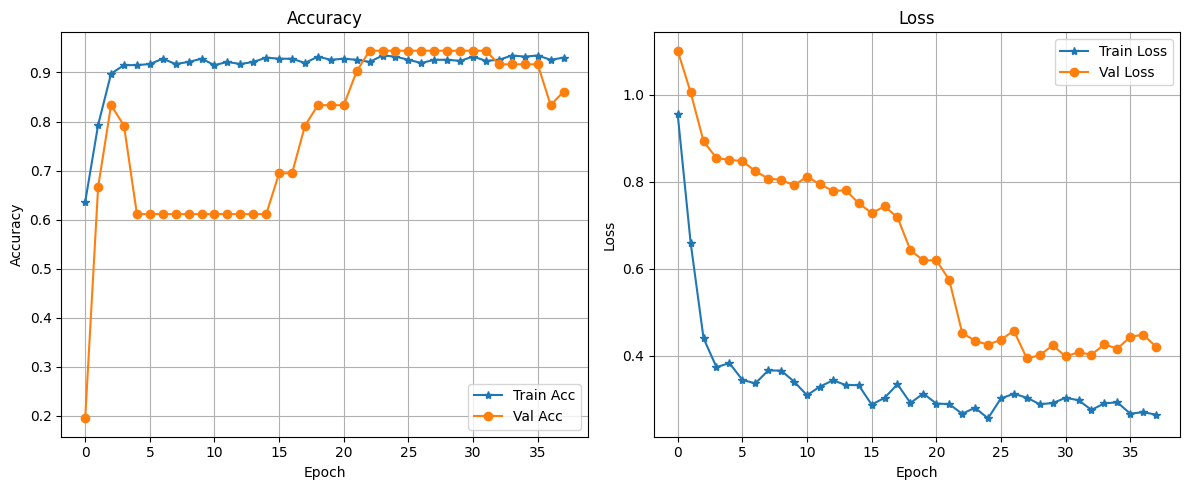


Test Accuracy: 0.8889
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  

Classification Report:
               precision    recall  f1-score   support

    Insomnia       1.00      0.57      0.73         7
        None       0.88      0.95      0.91        22
 Sleep Apnea       0.88      1.00      0.93         7

    accuracy                           0.89        36
   macro avg       0.92      0.84      0.86        36
weighted avg       0.90      0.89      0.88        36



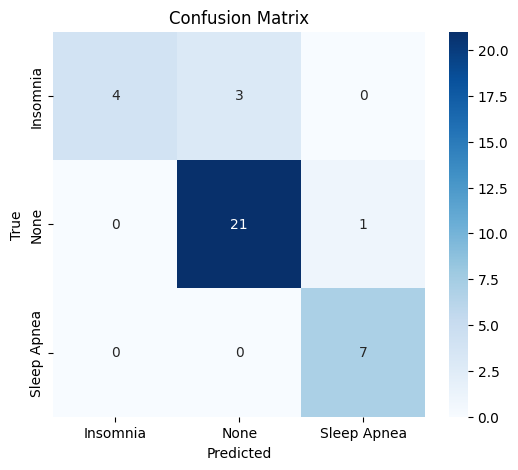

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, MaxPooling1D, 
                                     Dropout, Bidirectional, LSTM, Dense, Flatten, LeakyReLU)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Define model parameters
num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]

# Build CNN + BiLSTM model with LeakyReLU everywhere
model = Sequential([
    Input(shape=input_shape),

    Conv1D(32, 3, padding='same'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, 5, padding='same'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.4),

    Flatten(),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

# Define optimizer with custom learning rate, e.g., 0.0005
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', linestyle='-', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', linestyle='-', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', linestyle='-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
y_pred = np.argmax(model.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_67 (Conv1D)                   │ (None, 12, 16)              │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_69 (LeakyReLU)           │ (None, 12, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 6, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_151 (Dropout)                │ (None, 6, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_63 (Bidirectional)     │ (None, 6, 64)               │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_64 (Bidirectional)     │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_153 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 48)                  │           1,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_70 (LeakyReLU)           │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_154 (Dropout)                │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 3)                   │             147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,723 (96.57 KB)

 Trainable params: 24,723 (96.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
15/15 - 16s - 1s/step - accuracy: 0.3442 - loss: 1.0980 - val_accuracy: 0.1944 - val_loss: 1.0987
Epoch 2/80
15/15 - 0s - 15ms/step - accuracy: 0.3660 - loss: 1.0950 - val_accuracy: 0.1944 - val_loss: 1.1006
Epoch 3/80
15/15 - 0s - 15ms/step - accuracy: 0.3617 - loss: 1.0813 - val_accuracy: 0.1944 - val_loss: 1.1033
Epoch 4/80
15/15 - 0s - 15ms/step - accuracy: 0.4553 - loss: 1.0532 - val_accuracy: 0.3750 - val_loss: 1.0474
Epoch 5/80
15/15 - 0s - 15ms/step - accuracy: 0.5207 - loss: 0.9731 - val_accuracy: 0.6667 - val_loss: 0.8912
Epoch 6/80
15/15 - 0s - 15ms/step - accuracy: 0.6057 - loss: 0.8289 - val_accuracy: 0.7917 - val_loss: 0.5426
Epoch 7/80
15/15 - 0s - 15ms/step - accuracy: 0.6732 - loss: 0.7236 - val_accuracy: 0.9306 - val_loss: 0.4666
Epoch 8/80
15/15 - 0s - 15ms/step - accuracy: 0.7560 - loss: 0.6770 - val_accuracy: 0.8472 - val_loss: 0.5364
Epoch 9/80
15/15 - 0s - 16ms/step - accuracy: 0.7887 - loss: 0.6073 - val_accuracy: 0.8472 - val_loss: 0.4134
Epoch 10/80

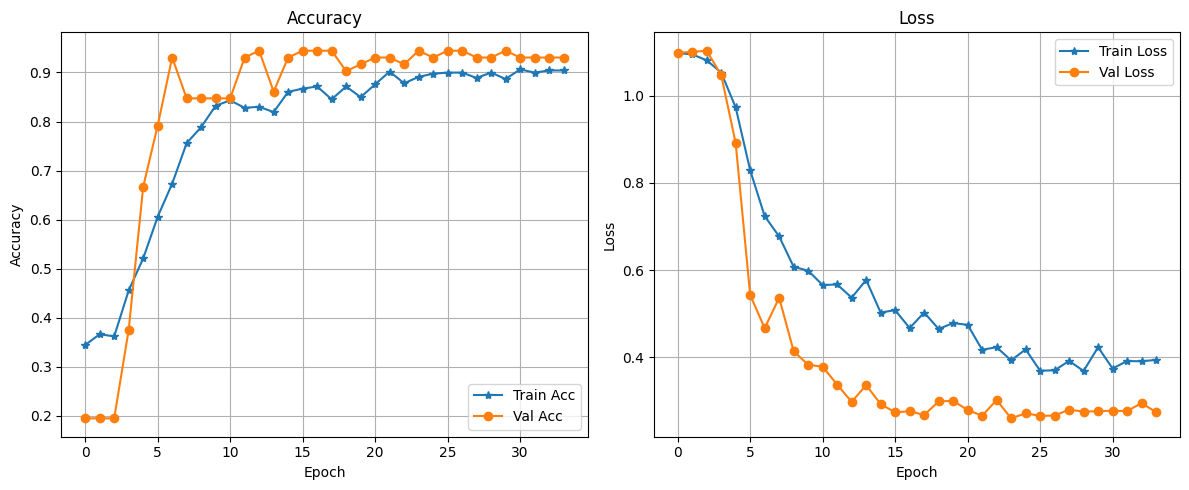


Test Accuracy: 0.8889
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 943ms/step

Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.83      0.71      0.77         7
        None       0.91      0.95      0.93        22
 Sleep Apnea       0.86      0.86      0.86         7

    accuracy                           0.89        36
   macro avg       0.87      0.84      0.85        36
weighted avg       0.89      0.89      0.89        36



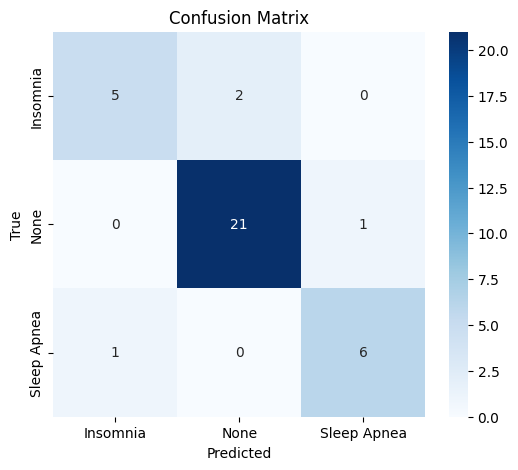

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, MaxPooling1D, 
                                     Dropout, Bidirectional, LSTM, Dense, Flatten, LeakyReLU)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Define model parameters
num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]

model = Sequential([
    Input(shape=input_shape),

    Conv1D(16, 4, padding='same'),          # increased filters and kernel size
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(16, return_sequences=False)),
    Dropout(0.25),

    Dense(48),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])


from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', linestyle='-', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', linestyle='-', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', linestyle='-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
y_pred = np.argmax(model.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.grid(False)
plt.show()


In [43]:
# Assuming the following variables are already defined from your preprocessing pipeline:
# X_train_res, y_train_res, X_test, y_test

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian NB": GaussianNB(),
    "SVM": SVC(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging": BaggingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Store results
results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# Print sorted results
print("\nAccuracy of 10 ML Models:\n")
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {acc:.4f}")



Accuracy of 10 ML Models:

Random Forest: 0.9167
XGBoost: 0.9167
Gradient Boosting: 0.8889
AdaBoost: 0.8889
Decision Tree: 0.8889
Extra Trees: 0.8889
Bagging: 0.8889
SVM: 0.8611
Logistic Regression: 0.8333
Gaussian NB: 0.8333


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout,
                                     BatchNormalization, Bidirectional, LSTM, Dense,
                                     Layer, Multiply, Permute, Activation, Lambda)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# --- Custom Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# --- Define Model Architecture ---
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)
num_classes = y_train_cat.shape[1]

inputs = Input(shape=input_shape)

x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

x = AttentionLayer()(x)  # Apply attention
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 12, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 6, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 3, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │             131 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,126 (520.02 KB)

 Trainable params: 132,742 (518.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/80
29/29 - 0s - 15ms/step - accuracy: 0.9368 - loss: 0.2426 - val_accuracy: 0.9444 - val_loss: 0.3703
Epoch 2/80
29/29 - 0s - 10ms/step - accuracy: 0.9434 - loss: 0.2489 - val_accuracy: 0.9444 - val_loss: 0.4020
Epoch 3/80
29/29 - 0s - 10ms/step - accuracy: 0.9412 - loss: 0.2104 - val_accuracy: 0.9444 - val_loss: 0.3940
Epoch 4/80
29/29 - 0s - 10ms/step - accuracy: 0.9434 - loss: 0.2281 - val_accuracy: 0.9444 - val_loss: 0.4075
Epoch 5/80
29/29 - 0s - 10ms/step - accuracy: 0.9390 - loss: 0.2642 - val_accuracy: 0.9444 - val_loss: 0.4034
Epoch 6/80
29/29 - 0s - 10ms/step - accuracy: 0.9412 - loss: 0.2332 - val_accuracy: 0.9306 - val_loss: 0.4247
Epoch 7/80
29/29 - 0s - 11ms/step - accuracy: 0.9434 - loss: 0.2330 - val_accuracy: 0.9167 - val_loss: 0.4328
Epoch 8/80
29/29 - 0s - 10ms/step - accuracy: 0.9434 - loss: 0.2527 - val_accuracy: 0.9444 - val_loss: 0.3880
Epoch 9/80
29/29 - 0s - 10ms/step - accuracy: 0.9412 - loss: 0.2228 - val_accuracy: 0.9444 - val_loss: 0.3829
Epoch 10/8

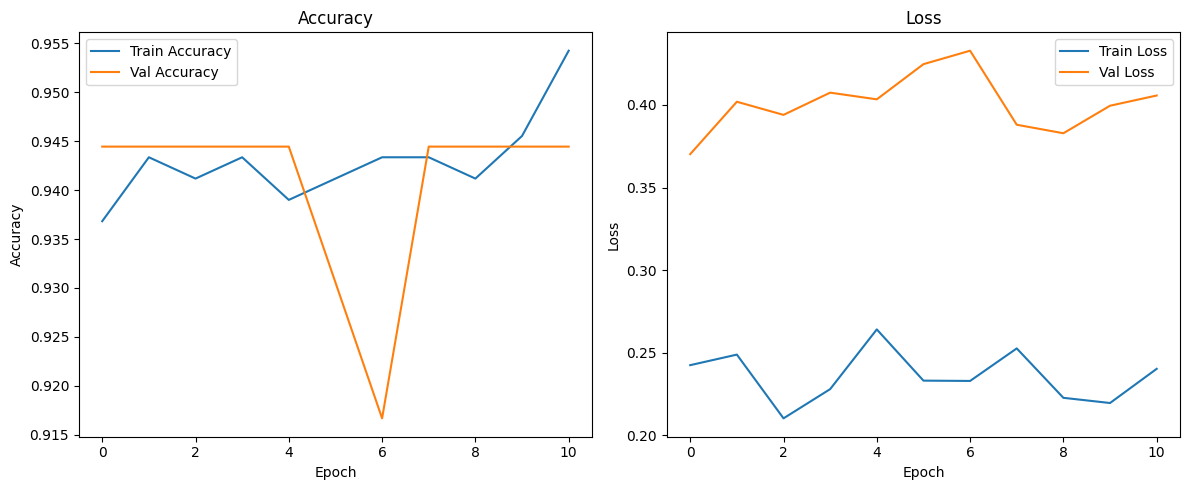


Test Accuracy: 0.8889
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Classification Report:
               precision    recall  f1-score   support

    Insomnia       1.00      0.71      0.83         7
        None       0.91      0.91      0.91        22
 Sleep Apnea       0.78      1.00      0.88         7

    accuracy                           0.89        36
   macro avg       0.90      0.87      0.87        36
weighted avg       0.90      0.89      0.89        36



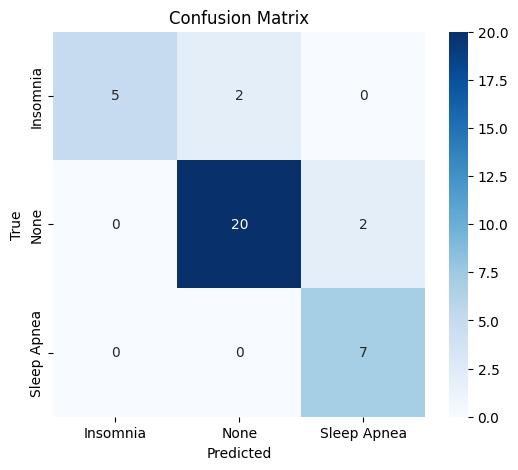

In [36]:
# Accuracy & Loss plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Test Evaluation
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred = np.argmax(model.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_85 (Conv1D)        │ (None, 12, 32)         │            128 │ input_layer_48[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_98            │ (None, 12, 32)         │              0 │ conv1d_85[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_69    │ (None, 12, 32)         │            128 │ leaky_re_lu_98[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_82          │ (None, 6, 32)          │              0 │ batch_normalization_6… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_205 (Dropout)     │ (None, 6, 32)          │              0 │ max_pooling1d_82[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 6, 32)          │         16,800 │ dropout_205[0][0],     │
│ (MultiHeadAttention)      │                        │                │ dropout_205[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_207 (Dropout)     │ (None, 6, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 6, 32)          │              0 │ dropout_205[0][0],     │
│                           │                        │                │ dropout_207[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 6, 32)          │             64 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_98 (Dense)          │ (None, 6, 64)          │          2,112 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_208 (Dropout)     │ (None, 6, 64)          │              0 │ dense_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_99 (Dense)          │ (None, 6, 32)          │          2,080 │ dropout_208[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 6, 32)          │              0 │ layer_normalization_4… │
│                           │                        │                │ dense_99[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 6, 32)          │             64 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 44,547 (174.01 KB)

 Trainable params: 44,483 (173.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/80
15/15 - 10s - 698ms/step - accuracy: 0.6296 - loss: 0.8906 - val_accuracy: 0.1944 - val_loss: 1.8196
Epoch 2/80
15/15 - 0s - 17ms/step - accuracy: 0.8388 - loss: 0.5919 - val_accuracy: 0.5417 - val_loss: 1.0724
Epoch 3/80
15/15 - 0s - 17ms/step - accuracy: 0.8693 - loss: 0.4974 - val_accuracy: 0.8611 - val_loss: 0.3789
Epoch 4/80
15/15 - 0s - 16ms/step - accuracy: 0.8954 - loss: 0.4629 - val_accuracy: 0.4861 - val_loss: 0.9536
Epoch 5/80
15/15 - 0s - 17ms/step - accuracy: 0.8954 - loss: 0.4186 - val_accuracy: 0.8611 - val_loss: 0.4377
Epoch 6/80
15/15 - 0s - 17ms/step - accuracy: 0.9150 - loss: 0.3821 - val_accuracy: 0.9028 - val_loss: 0.3214
Epoch 7/80
15/15 - 0s - 17ms/step - accuracy: 0.9216 - loss: 0.3610 - val_accuracy: 0.8750 - val_loss: 0.3650
Epoch 8/80
15/15 - 0s - 17ms/step - accuracy: 0.9237 - loss: 0.3672 - val_accuracy: 0.9028 - val_loss: 0.3566
Epoch 9/80
15/15 - 0s - 17ms/step - accuracy: 0.9172 - loss: 0.3591 - val_accuracy: 0.8611 - val_loss: 0.3595
Epoch 10

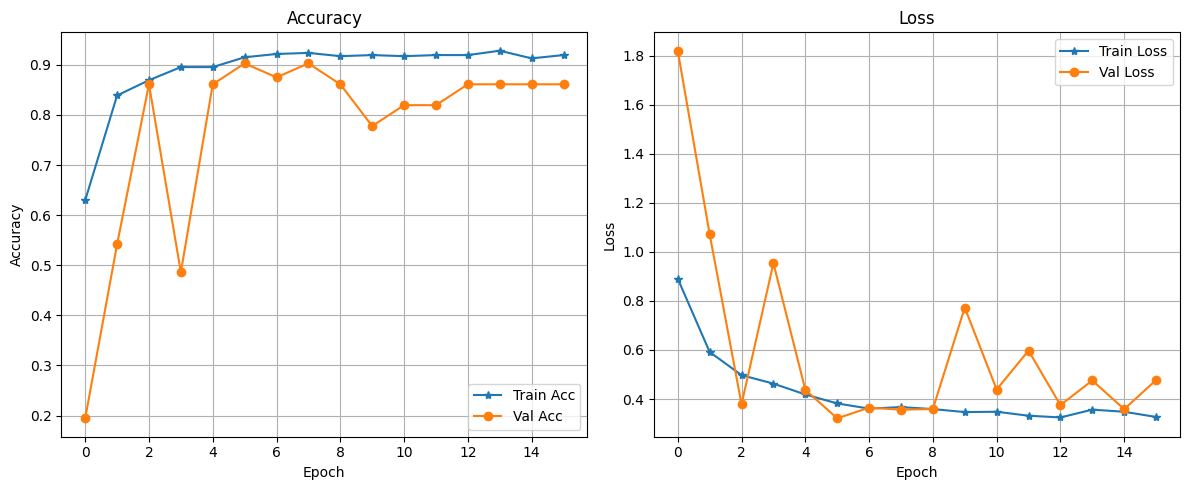


Test Accuracy: 0.8333
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step

Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.56      0.71      0.62         7
        None       0.90      0.86      0.88        22
 Sleep Apnea       1.00      0.86      0.92         7

    accuracy                           0.83        36
   macro avg       0.82      0.81      0.81        36
weighted avg       0.86      0.83      0.84        36



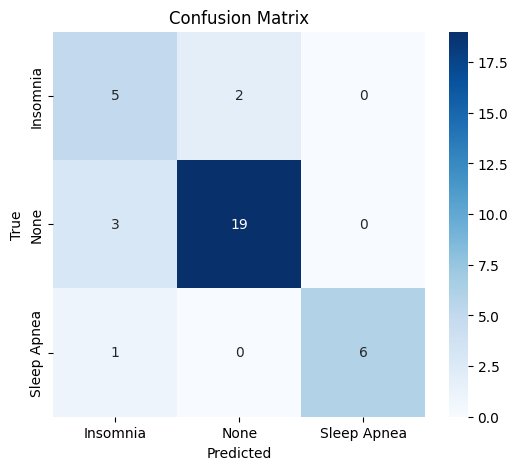

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, MaxPooling1D, Dropout,
                                     GRU, Dense, Flatten, LeakyReLU, LayerNormalization,
                                     MultiHeadAttention, Add, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping

# Transformer Encoder block
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout=0.2):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed-forward network
    ffn = Dense(ff_dim, activation='relu')(attention_output)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Add()([attention_output, ffn])  # Residual connection
    output = LayerNormalization(epsilon=1e-6)(ffn)
    return output

num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]

inputs = Input(shape=input_shape)

# Step 1: Local feature extraction with CNN
x = Conv1D(32, kernel_size=3, padding='same')(inputs)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

# Step 2: Transformer Encoder block for global context
x = transformer_encoder(x, num_heads=4, ff_dim=64, dropout=0.2)

# Step 3: GRU layer to learn sequential dependencies
x = GRU(64, return_sequences=False)(x)
x = Dropout(0.3)(x)

# Step 4: Dense classification layers
x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# You can add your plotting, evaluation, classification report, confusion matrix etc. here as before.
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', linestyle='-', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', linestyle='-', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', linestyle='-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
y_pred = np.argmax(model.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.grid(False)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 12, 32)         │            128 │ input_layer_51[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_110           │ (None, 12, 32)         │              0 │ conv1d_94[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_78    │ (None, 12, 32)         │            128 │ leaky_re_lu_110[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 32)             │              0 │ batch_normalization_7… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_126 (Dense)         │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_127 (Dense)         │ (None, 32)             │             96 │ dense_126[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 1, 32)          │              0 │ dense_127[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 12, 32)         │              0 │ batch_normalization_7… │
│                           │                        │                │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_229 (Dropout)     │ (None, 12, 32)         │              0 │ multiply_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 12, 32)         │          3,104 │ dropout_229[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_111           │ (None, 12, 32)         │              0 │ conv1d_95[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_79    │ (None, 12, 32)         │            128 │ leaky_re_lu_111[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 32)             │              0 │ batch_normalization_7… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_128 (Dense)         │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_129 (Dense)    

 Total params: 136,559 (533.43 KB)

 Trainable params: 136,175 (531.93 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/80
15/15 - 24s - 2s/step - accuracy: 0.5294 - loss: 0.9862 - val_accuracy: 0.1944 - val_loss: 1.5067
Epoch 2/80
15/15 - 0s - 25ms/step - accuracy: 0.7647 - loss: 0.6831 - val_accuracy: 0.1944 - val_loss: 2.2493
Epoch 3/80
15/15 - 0s - 25ms/step - accuracy: 0.8540 - loss: 0.4886 - val_accuracy: 0.1944 - val_loss: 1.7276
Epoch 4/80
15/15 - 0s - 25ms/step - accuracy: 0.8867 - loss: 0.4181 - val_accuracy: 0.1944 - val_loss: 1.5210
Epoch 5/80
15/15 - 0s - 25ms/step - accuracy: 0.8845 - loss: 0.3910 - val_accuracy: 0.1944 - val_loss: 1.3216
Epoch 6/80
15/15 - 0s - 25ms/step - accuracy: 0.9020 - loss: 0.3866 - val_accuracy: 0.1944 - val_loss: 1.2132
Epoch 7/80
15/15 - 0s - 25ms/step - accuracy: 0.8976 - loss: 0.4151 - val_accuracy: 0.6111 - val_loss: 0.8722
Epoch 8/80
15/15 - 0s - 26ms/step - accuracy: 0.8954 - loss: 0.3918 - val_accuracy: 0.6111 - val_loss: 0.8653
Epoch 9/80
15/15 - 0s - 25ms/step - accuracy: 0.9063 - loss: 0.3755 - val_accuracy: 0.2639 - val_loss: 1.0261
Epoch 10/80

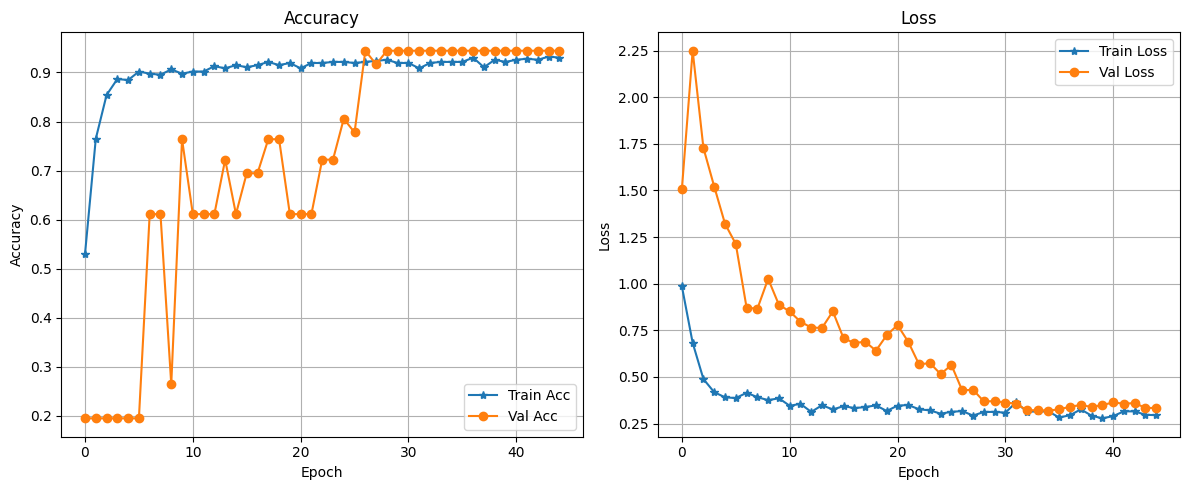


Test Accuracy: 0.8889
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 907ms/step

Classification Report:
               precision    recall  f1-score   support

    Insomnia       0.83      0.71      0.77         7
        None       0.91      0.91      0.91        22
 Sleep Apnea       0.88      1.00      0.93         7

    accuracy                           0.89        36
   macro avg       0.87      0.87      0.87        36
weighted avg       0.89      0.89      0.89        36



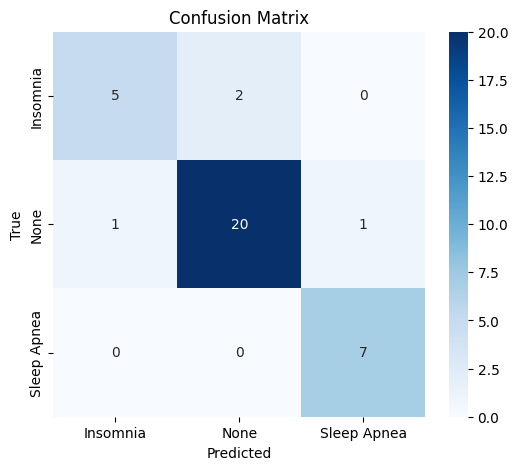

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Dropout, GRU, Dense, LeakyReLU, 
                                     GlobalAveragePooling1D, Multiply, Reshape, Add, LayerNormalization,
                                     MultiHeadAttention, MaxPooling1D)

def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    x = Multiply()([input_tensor, se])
    return x

def tcn_block(x, filters, kernel_size=3, dilation_rate=1, dropout=0.2):
    # Causal Conv1D with dilation
    conv = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    conv = LeakyReLU(alpha=0.1)(conv)
    conv = BatchNormalization()(conv)
    conv = squeeze_excite_block(conv)
    conv = Dropout(dropout)(conv)
    return conv

def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout=0.2):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn = Dropout(dropout)(attn)
    attn = Add()([inputs, attn])
    attn = LayerNormalization(epsilon=1e-6)(attn)

    ff = Dense(ff_dim, activation='relu')(attn)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Add()([attn, ff])
    output = LayerNormalization(epsilon=1e-6)(ff)
    return output

num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]

inputs = Input(shape=input_shape)

# Temporal Convolutional Blocks with increasing dilation
x = tcn_block(inputs, 32, dilation_rate=1)
x = tcn_block(x, 32, dilation_rate=2)
x = MaxPooling1D(pool_size=2)(x)

x = tcn_block(x, 64, dilation_rate=4)
x = tcn_block(x, 64, dilation_rate=8)
x = MaxPooling1D(pool_size=2)(x)

# Transformer Encoder block for global attention
x = transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.2)

# GRU layer for sequential modeling
x = GRU(64)(x)
x = Dropout(0.3)(x)

# Dense layers with LeakyReLU and Dropout
x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# You can add your plotting and evaluation code after this.
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', linestyle='-', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', linestyle='-', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', linestyle='-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
y_pred = np.argmax(model.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.grid(False)
plt.show()


Epoch 1/80
15/15 - 0s - 31ms/step - accuracy: 0.9194 - loss: 0.2987 - val_accuracy: 0.9444 - val_loss: 0.3627
Epoch 2/80
15/15 - 0s - 26ms/step - accuracy: 0.9237 - loss: 0.3036 - val_accuracy: 0.9444 - val_loss: 0.3747
Epoch 3/80
15/15 - 0s - 25ms/step - accuracy: 0.9194 - loss: 0.3234 - val_accuracy: 0.9444 - val_loss: 0.3780
Epoch 4/80
15/15 - 0s - 25ms/step - accuracy: 0.9281 - loss: 0.2870 - val_accuracy: 0.9444 - val_loss: 0.3890
Epoch 5/80
15/15 - 0s - 24ms/step - accuracy: 0.9216 - loss: 0.3017 - val_accuracy: 0.9444 - val_loss: 0.3636
Epoch 6/80
15/15 - 0s - 24ms/step - accuracy: 0.9194 - loss: 0.3181 - val_accuracy: 0.9444 - val_loss: 0.3791
Epoch 7/80
15/15 - 0s - 25ms/step - accuracy: 0.9216 - loss: 0.2941 - val_accuracy: 0.9444 - val_loss: 0.3814
Epoch 8/80
15/15 - 0s - 24ms/step - accuracy: 0.9281 - loss: 0.3012 - val_accuracy: 0.9444 - val_loss: 0.3707
Epoch 9/80
15/15 - 0s - 26ms/step - accuracy: 0.9237 - loss: 0.2883 - val_accuracy: 0.9444 - val_loss: 0.3814
Epoch 10/8

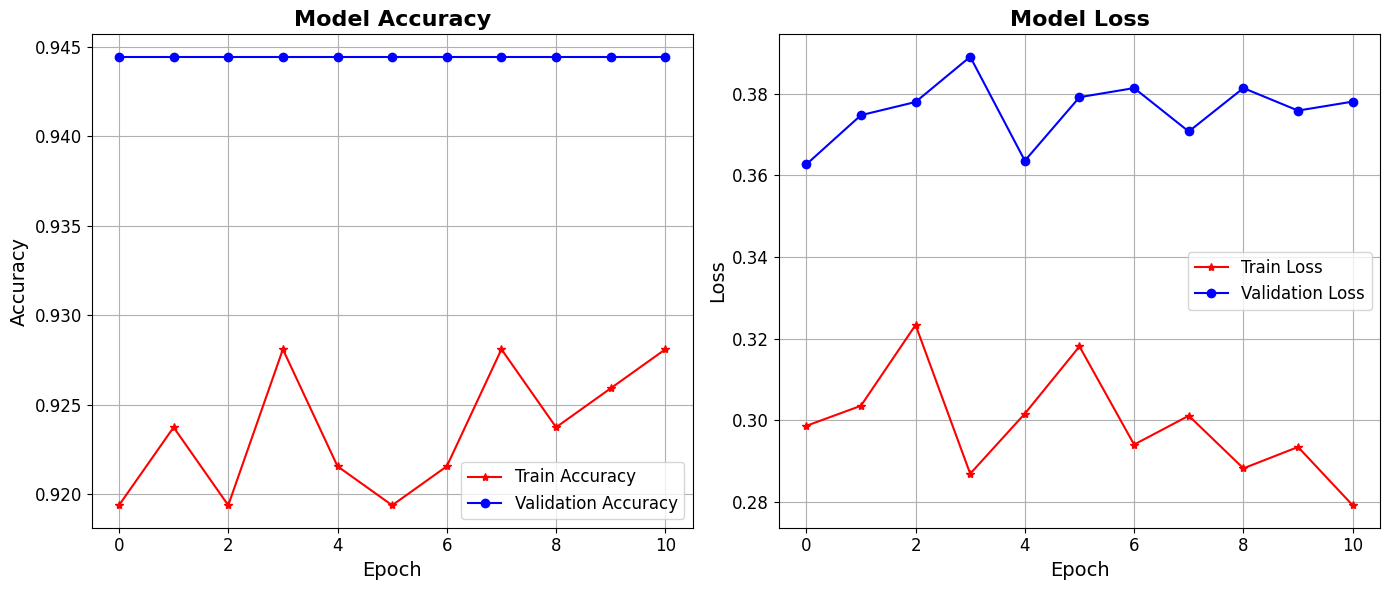


Test Accuracy: 0.8889
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Classification Report:

              precision    recall  f1-score   support

    Insomnia       0.83      0.71      0.77         7
        None       0.91      0.91      0.91        22
 Sleep Apnea       0.88      1.00      0.93         7

    accuracy                           0.89        36
   macro avg       0.87      0.87      0.87        36
weighted avg       0.89      0.89      0.89        36



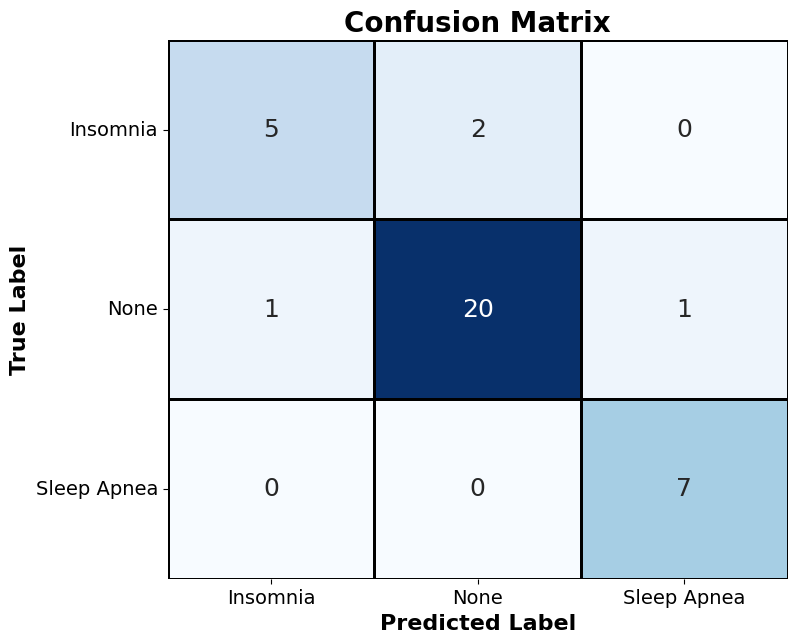

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming your model has been compiled and trained:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Plot Accuracy and Loss with red '*' and blue 'o'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', color='red', linestyle='-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', color='blue', linestyle='-', label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', color='red', linestyle='-', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', color='blue', linestyle='-', label='Validation Loss')
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predict test labels
y_pred_probs = model.predict(X_test_3d)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_,
            annot_kws={"size": 18},  # Bigger font size for numbers
            cbar=False, linewidths=1, linecolor='black')

plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.grid(False)

plt.show()


In [88]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LayerNormalization,
                                     Dropout, MultiHeadAttention, GlobalAveragePooling1D, Add)
from tensorflow.keras.optimizers import Adam

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(sequence_len, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'pos_encoding': self.pos_encoding.numpy(),
        })
        return config

    def positional_encoding(self, seq_len, d_model):
        pos = tf.range(seq_len)[:, tf.newaxis]  # shape (seq_len, 1)
        i = tf.range(d_model)[tf.newaxis, :]    # shape (1, d_model)
        angle_rates = 1 / tf.pow(10000., (2 * tf.cast(i // 2, tf.float32)) / tf.cast(d_model, tf.float32))
        angle_rads = tf.cast(pos, tf.float32) * angle_rates
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Build the model
sequence_len = X_train_res_3d.shape[1]  # e.g. 12 timesteps
features = X_train_res_3d.shape[2]      # e.g. 1 feature per timestep
num_classes = y_train_cat.shape[1]

inputs = Input(shape=(sequence_len, features))
x = PositionalEncoding(sequence_len, features)(inputs)

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_1     │ (None, 12, 1)          │              0 │ input_layer_53[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_6    │ (None, 12, 1)          │          1,793 │ positional_encoding_1… │
│ (MultiHeadAttention)      │                        │                │ positional_encoding_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_239 (Dropout)     │ (None, 12, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 12, 1)          │              0 │ dropout_239[0][0],     │
│                           │                        │                │ positional_encoding_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 12, 1)          │              2 │ add_12[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_138 (Dense)         │ (None, 12, 128)        │            256 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_240 (Dropout)     │ (None, 12, 128)        │              0 │ dense_138[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_139 (Dense)         │ (None, 12, 1)          │            129 │ dropout_240[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 12, 1)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dense_139[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 12, 1)          │              2 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 12, 1)          │          1,793 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_242 (Dropout)     │ (None, 12, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 12, 1)          │              0 │ dropout_242[0][0],     │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 12, 1)          │              2 │ add_14[0][0]           │
│ (LayerNormalization) 

 Total params: 4,687 (18.31 KB)

 Trainable params: 4,687 (18.31 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/80
15/15 - 0s - 28ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0981
Epoch 2/80
15/15 - 0s - 21ms/step - accuracy: 0.3333 - loss: 1.0987 - val_accuracy: 0.6111 - val_loss: 1.0976
Epoch 3/80
15/15 - 0s - 18ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0977
Epoch 4/80
15/15 - 0s - 17ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0980
Epoch 5/80
15/15 - 0s - 18ms/step - accuracy: 0.3333 - loss: 1.0987 - val_accuracy: 0.6111 - val_loss: 1.0976
Epoch 6/80
15/15 - 0s - 20ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0977
Epoch 7/80
15/15 - 0s - 18ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0976
Epoch 8/80
15/15 - 0s - 18ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0979
Epoch 9/80
15/15 - 0s - 18ms/step - accuracy: 0.3333 - loss: 1.0986 - val_accuracy: 0.6111 - val_loss: 1.0975
Epoch 10/8

In [92]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, 
                                     MaxPooling1D, Dropout, Bidirectional, 
                                     LSTM, Dense, Flatten, LeakyReLU)
from tensorflow.keras.optimizers import Adam

# Define model parameters
num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)

model = Sequential([
    Input(shape=input_shape),

    # TCN-like block: Dilated Conv1D layers
    Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    
    Conv1D(64, kernel_size=3, dilation_rate=2, padding='causal'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    
    Conv1D(64, kernel_size=3, dilation_rate=4, padding='causal'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    # BiLSTM to capture temporal dependencies
    Bidirectional(LSTM(64)),
    Dropout(0.4),

    # Classification head
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_98 (Conv1D)                   │ (None, 12, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_115 (LeakyReLU)          │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_82               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_99 (Conv1D)                   │ (None, 12, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_116 (LeakyReLU)          │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_83               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_100 (Conv1D)                  │ (None, 12, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_117 (LeakyReLU)          │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_84               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_246 (Dropout)                │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_80 (Bidirectional)     │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_247 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_118 (LeakyReLU)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_248 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,227 (391.51 KB)

 Trainable params: 99,843 (390.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/80
15/15 - 10s - 676ms/step - accuracy: 0.5359 - loss: 0.9619 - val_accuracy: 0.9306 - val_loss: 1.0887
Epoch 2/80
15/15 - 0s - 19ms/step - accuracy: 0.8410 - loss: 0.6313 - val_accuracy: 0.6111 - val_loss: 1.0738
Epoch 3/80
15/15 - 0s - 20ms/step - accuracy: 0.8736 - loss: 0.4844 - val_accuracy: 0.6111 - val_loss: 1.0484
Epoch 4/80
15/15 - 0s - 19ms/step - accuracy: 0.8889 - loss: 0.3943 - val_accuracy: 0.6111 - val_loss: 1.0142
Epoch 5/80
15/15 - 0s - 19ms/step - accuracy: 0.9085 - loss: 0.3575 - val_accuracy: 0.6389 - val_loss: 1.0024
Epoch 6/80
15/15 - 0s - 19ms/step - accuracy: 0.8976 - loss: 0.3674 - val_accuracy: 0.6111 - val_loss: 0.9722
Epoch 7/80
15/15 - 0s - 19ms/step - accuracy: 0.9107 - loss: 0.3589 - val_accuracy: 0.6111 - val_loss: 0.9443
Epoch 8/80
15/15 - 0s - 19ms/step - accuracy: 0.9150 - loss: 0.3316 - val_accuracy: 0.6111 - val_loss: 0.9279
Epoch 9/80
15/15 - 0s - 19ms/step - accuracy: 0.9259 - loss: 0.3192 - val_accuracy: 0.6111 - val_loss: 0.8981
Epoch 10

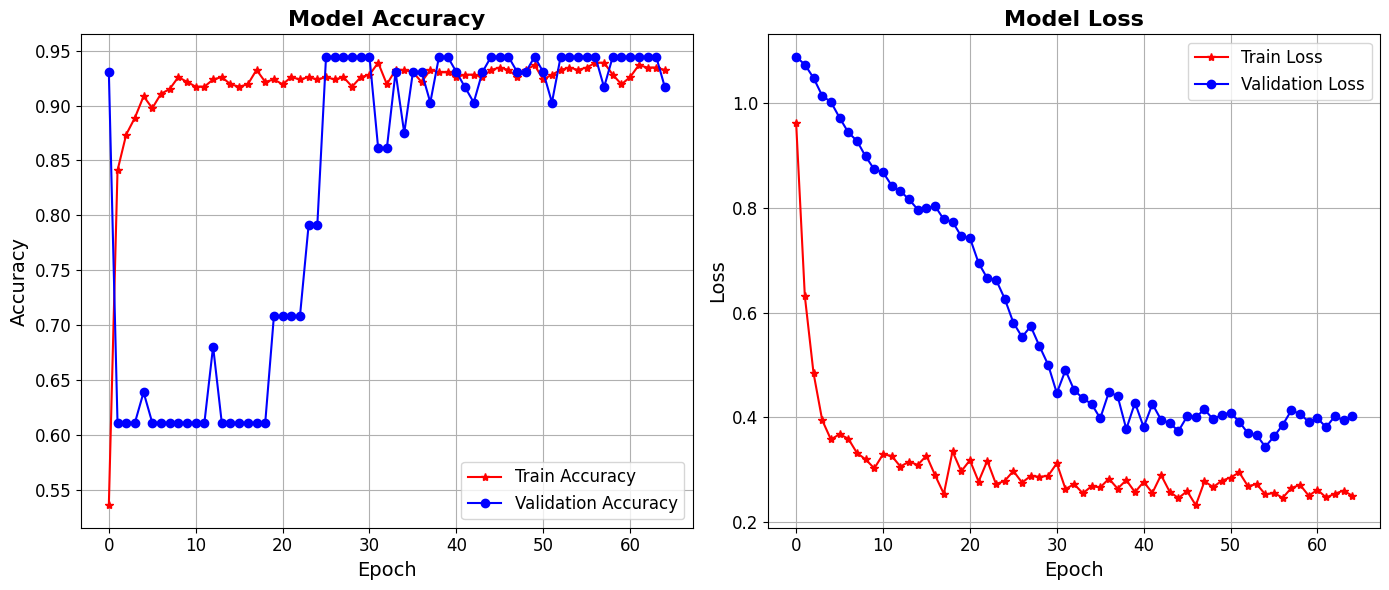


Test Accuracy: 0.9167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step

Classification Report:

              precision    recall  f1-score   support

    Insomnia       1.00      0.71      0.83         7
        None       0.91      0.95      0.93        22
 Sleep Apnea       0.88      1.00      0.93         7

    accuracy                           0.92        36
   macro avg       0.93      0.89      0.90        36
weighted avg       0.92      0.92      0.91        36



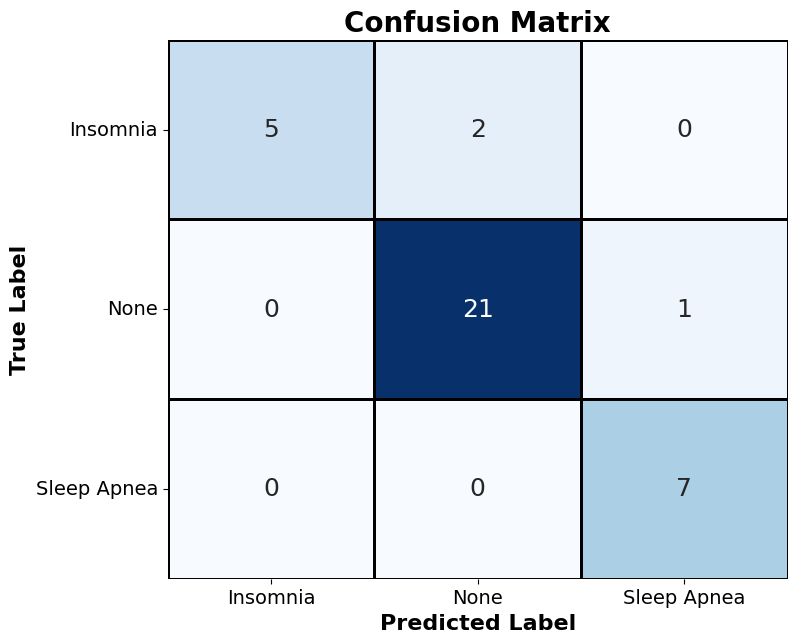

In [94]:
# Plot Accuracy and Loss with red '*' and blue 'o'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', color='red', linestyle='-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', color='blue', linestyle='-', label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', color='red', linestyle='-', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', color='blue', linestyle='-', label='Validation Loss')
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predict test labels
y_pred_probs = model.predict(X_test_3d)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_,
            annot_kws={"size": 18},  # Bigger font size for numbers
            cbar=False, linewidths=1, linecolor='black')

plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.grid(False)

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_101 (Conv1D)                  │ (None, 12, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_119 (LeakyReLU)          │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_85               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_102 (Conv1D)                  │ (None, 12, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_120 (LeakyReLU)          │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_86               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_103 (Conv1D)                  │ (None, 12, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_121 (LeakyReLU)          │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_87               │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_249 (Dropout)                │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_81 (Bidirectional)     │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_250 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_122 (LeakyReLU)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_251 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,227 (391.51 KB)

 Trainable params: 99,843 (390.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/80
15/15 - 10s - 673ms/step - accuracy: 0.5969 - loss: 0.9499 - val_accuracy: 0.2500 - val_loss: 1.0945
Epoch 2/80
15/15 - 0s - 19ms/step - accuracy: 0.8649 - loss: 0.6222 - val_accuracy: 0.3333 - val_loss: 1.0819
Epoch 3/80
15/15 - 0s - 19ms/step - accuracy: 0.8932 - loss: 0.4553 - val_accuracy: 0.1944 - val_loss: 1.0742
Epoch 4/80
15/15 - 0s - 20ms/step - accuracy: 0.9107 - loss: 0.3972 - val_accuracy: 0.1944 - val_loss: 1.0722
Epoch 5/80
15/15 - 0s - 19ms/step - accuracy: 0.9020 - loss: 0.3498 - val_accuracy: 0.1944 - val_loss: 1.0819
Epoch 6/80
15/15 - 0s - 19ms/step - accuracy: 0.9085 - loss: 0.3556 - val_accuracy: 0.1944 - val_loss: 1.1056
Epoch 7/80
15/15 - 0s - 19ms/step - accuracy: 0.9107 - loss: 0.3373 - val_accuracy: 0.1944 - val_loss: 1.0737
Epoch 8/80
15/15 - 0s - 19ms/step - accuracy: 0.9194 - loss: 0.3433 - val_accuracy: 0.1944 - val_loss: 1.0676
Epoch 9/80
15/15 - 0s - 20ms/step - accuracy: 0.9107 - loss: 0.3373 - val_accuracy: 0.1944 - val_loss: 1.0225
Epoch 10

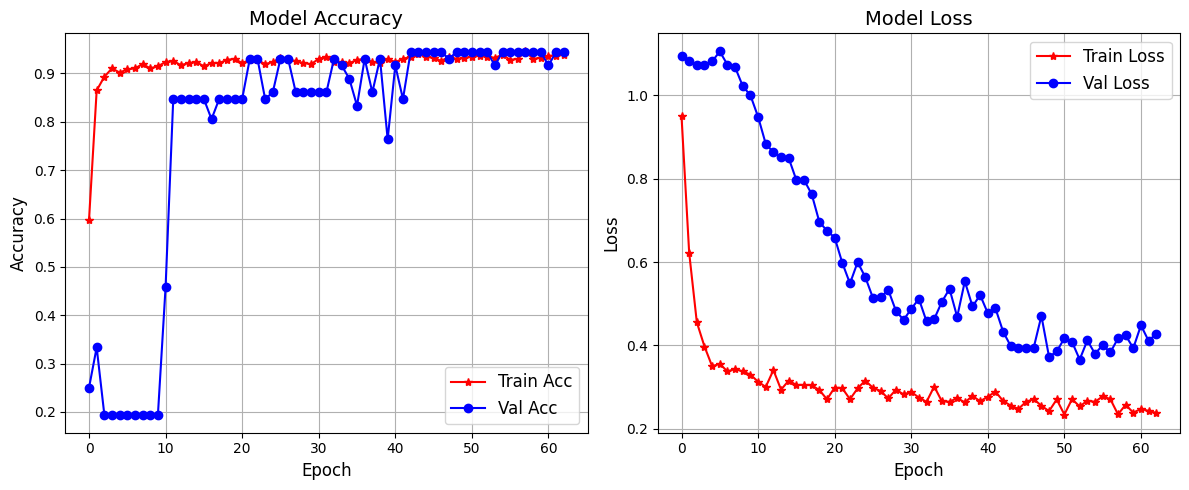


Test Accuracy: 0.9167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step

Classification Report:
               precision    recall  f1-score   support

    Insomnia       1.00      0.71      0.83         7
        None       0.91      0.95      0.93        22
 Sleep Apnea       0.88      1.00      0.93         7

    accuracy                           0.92        36
   macro avg       0.93      0.89      0.90        36
weighted avg       0.92      0.92      0.91        36



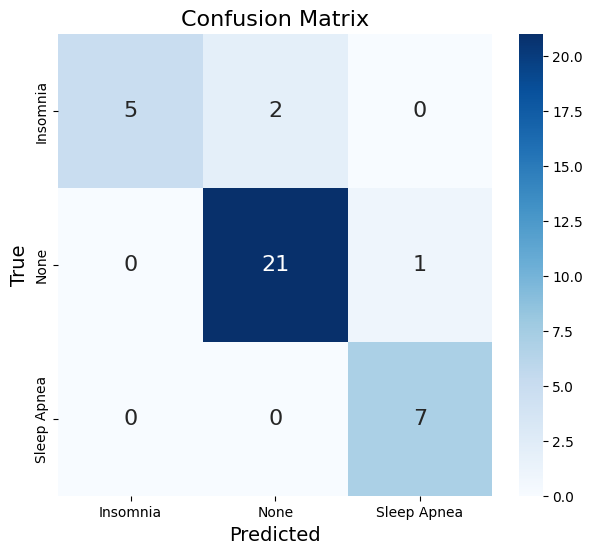

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, 
                                     Dropout, Bidirectional, LSTM, Dense, LeakyReLU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Model params
num_classes = y_train_cat.shape[1]
input_shape = X_train_res_3d.shape[1:]  # (timesteps, features)

# Build TCN + BiLSTM model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    
    Conv1D(64, kernel_size=3, dilation_rate=2, padding='causal'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    
    Conv1D(64, kernel_size=3, dilation_rate=4, padding='causal'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.4),

    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_res_3d, y_train_cat,
    validation_data=(X_val_3d, y_val_cat),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='*', linestyle='-', color='red', label='Train Acc')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', color='blue', label='Val Acc')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='*', linestyle='-', color='red', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', linestyle='-', color='blue', label='Val Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions and metrics
y_pred = np.argmax(model.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))

# Confusion matrix with larger font and grid off
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_,
            annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.grid(False)
plt.show()


In [101]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Base models (avoid XGBClassifier for now due to compatibility)
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('gnb', GaussianNB())
]

# Meta-model
meta_model = LogisticRegression(max_iter=1000)

# Stacking ensemble
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=1  # avoids parallel issues
)

# Train
stacked_model.fit(X_train_res, y_train_res)

# Predict
y_pred_stack = stacked_model.predict(X_test)

# Accuracy
stacked_acc = accuracy_score(y_test, y_pred_stack)
print(f"\n✅ Stacked Ensemble Accuracy: {stacked_acc:.4f}")



✅ Stacked Ensemble Accuracy: 0.8889


In [103]:
!pip install catboost lightgbm xgboost


In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Load dataset
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# Fill missing target
df['Sleep Disorder'].fillna('None', inplace=True)

# Impute numeric values
num_cols = ['Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
df[num_cols] = SimpleImputer(strategy='mean').fit_transform(df[num_cols])

# Process Blood Pressure
df['Blood Pressure'].fillna(df['Blood Pressure'].mode()[0], inplace=True)
bp = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(bp[0])
df['Diastolic_BP'] = pd.to_numeric(bp[1])
df.drop(columns=['Blood Pressure'], inplace=True)

# Encode categorical features
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Occupation'] = LabelEncoder().fit_transform(df['Occupation'])
df['BMI Category'] = LabelEncoder().fit_transform(df['BMI Category'])
df['Sleep Disorder Encoded'] = LabelEncoder().fit_transform(df['Sleep Disorder'])

# Prepare X and y
X = df.drop(columns=['Person ID', 'Sleep Disorder', 'Sleep Disorder Encoded'])
y = df['Sleep Disorder Encoded']

# Scale features
X_scaled = MinMaxScaler().fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Models
models = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


/tmp/ipykernel_95/919245249.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sleep Disorder'].fillna('None', inplace=True)
/tmp/ipykernel_95/919245249.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

✅ CatBoost Accuracy: 0.9333
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      0.98      0.99        44
           2       0.93      0.81      0.87        16

    accuracy                           0.93        75
   macro avg       0.90      0.91      0.90        75
weighted avg       0.94      0.93      0.93        75

------------------------------------------------------------
✅ XGBoost Accuracy: 0.9333
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       1.00      0.98      0.99        44
           2       0.93      0.81      0.87        16

    accuracy                           0.93        75
   macro avg       0.90      0.91      0.90        75
weighted avg       0.94      0.93      0.93        75

------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 525, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [106]:
# Required Libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Define base learners
base_learners = [
    ('lightgbm', LGBMClassifier(random_state=42)),
    ('gboost', GradientBoostingClassifier(random_state=42)),
    ('adaboost', AdaBoostClassifier(random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42))
]

# Meta-learner (final classifier)
meta_learner = LogisticRegression()

# Build stacked model
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Fit on training data
stacked_model.fit(X_train_res, y_train_res)

# Predict on test data
y_pred = stacked_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Stacked Ensemble Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 525, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✅ Stacked Ensemble Accuracy: 0.9467

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.93      0.88        15
           1       1.00      1.00      1.00        44
           2       0.93      0.81      0.87        16

    accuracy                           0.95        75
   macro avg       0.92      0.92      0.91        75
weighted avg       0.95      0.95      0.95        75



In [107]:
# Imports
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Base learners
base_models = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('gboost', GradientBoostingClassifier(random_state=42)),
    ('cat', CatBoostClassifier(verbose=0, random_state=42))
]

# Meta learner: AdaBoost (best performer in your result)
meta_model = AdaBoostClassifier(random_state=42)

# Stacked model
stacked_ensemble = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# Train
stacked_ensemble.fit(X_train_res, y_train_res)

# Predict
y_pred = stacked_ensemble.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Stacked Model (AdaBoost Meta) Accuracy: {acc:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 525, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [108]:
pip install mlxtend


Note: you may need to restart the kernel to use updated packages.


In [109]:
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

base_models = [
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    LGBMClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    CatBoostClassifier(verbose=0, random_state=42)
]

meta_model = AdaBoostClassifier(random_state=42)

stack = StackingClassifier(
    classifiers=base_models,
    meta_classifier=meta_model,
    use_probas=True,
    average_probas=False
)

stack.fit(X_train_res, y_train_res)
y_pred = stack.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Stacked Ensemble Accuracy (mlxtend): {acc:.4f}")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 525, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur